# **Spatial-Spectral Summarizer Fusion Network (S³F-Net)**

This notebook contains the full implementation of **S³F-Net** on the Breast Ultrasound Images (BUSI) dataset. We use the **SpectraNet-2** variant as the spectral encoder here, and use simple **Concatenation Fusion** to fuse the two branches (Spatial & Spectral). The full architecture is customizable, feel free to do so. Edit the file paths according to your setup.

## **Data Preparation**

In [ ]:
# ==============================================================================
# BLOCK 1: SETUP, IMPORTS AND DATA LOADING (FOR BUSI)
# ==============================================================================
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, cohen_kappa_score, matthews_corrcoef, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns

# --- Setup ---
print("--- Mounting Google Drive ---")
drive.mount('/content/drive')

# --- Configuration ---
IMG_SIZE = (256, 256)
BATCH_SIZE = 16
EPOCHS = 200
RANDOM_STATE = 42

# --- Paths ---
DATASET_PATH = "/content/drive/MyDrive/Medical Image Segmentation/Breast Ultrasound Images/Breast Ultrasound Images/Dataset_BUSI_with_GT"
SAVE_FOLDER = "/content/drive/MyDrive/S3F_Net_Models"
os.makedirs(SAVE_FOLDER, exist_ok=True)
CLASSIFIER_MODEL_PATH = os.path.join(SAVE_FOLDER, "Concatenation_S3f_net_SN2_BUSI.keras")

In [ ]:
# ==============================================================================
# BLOCK 2: DATA LOADING AND PREPROCESSING FOR BUSI
# ==============================================================================
def load_busi_dataset(dataset_path):
    """Loads images and labels from the BUSI dataset structure."""
    categories = ['benign', 'malignant', 'normal']
    images, labels = [], []
    print(f"Loading BUSI dataset from: {dataset_path}")
    for class_idx, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        if not os.path.exists(category_path) or not os.path.isdir(category_path): continue
        for filename in os.listdir(category_path):
            if '_mask' in filename or not filename.lower().endswith('.png'): continue
            img_path = os.path.join(category_path, filename)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None: continue
                img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
                img = img.astype('float32') / 255.0
                images.append(img[..., np.newaxis])
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    if not images: raise ValueError("No images loaded.")
    return np.array(images), np.array(labels), categories

try:
    images, labels, CLASS_NAMES = load_busi_dataset(DATASET_PATH)
    print(f"Dataset loaded successfully: {len(images)} images.")
    indices = np.arange(len(images))
    train_indices, test_indices = train_test_split(indices, test_size=0.2, stratify=labels, random_state=RANDOM_STATE)
    X_train, X_test = images[train_indices], images[test_indices]
    y_train, y_test = labels[train_indices], labels[test_indices]
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = dict(enumerate(class_weights))
    print(f"\nClass names: {CLASS_NAMES}")
    print(f"Data split: {len(X_train)} training, {len(X_test)} testing samples.")
    X_val, y_val = X_test, y_test

except Exception as e:
    print(f"An error occurred during data loading: {e}"); exit()

Loading BUSI dataset from: /content/drive/MyDrive/Medical Image Segmentation/Breast Ultrasound Images/Breast Ultrasound Images/Dataset_BUSI_with_GT
Dataset loaded successfully: 780 images.

Class names: ['benign', 'malignant', 'normal']
Data split: 624 training, 156 testing samples.


## **S³F-Net (Concatenation-Fusion SN2 Variant) Model Building**

In [1]:
# ==============================================================================
# BLOCK 3: MODEL ARCHITECTURE (CONCATENATION FUSION FOR BUSI)
# ==============================================================================
# This block defines the S³F-Net with SpectraNet-2 + Concatenation Fusion

# --- Custom SpectralFilter Layer & Encoders ---
class SpectralFilterLayer(layers.Layer):
    def __init__(self, filters, **kwargs): super().__init__(**kwargs); self.filters = filters
    def build(self, input_shape):
        _, h, w, c = input_shape
        fft_shape = (h, w // 2 + 1)
        self.real_weights = self.add_weight(name='real_weights', shape=(c, self.filters, *fft_shape), initializer='glorot_uniform')
        self.imag_weights = self.add_weight(name='imag_weights', shape=(c, self.filters, *fft_shape), initializer='glorot_uniform')
        self.bias = self.add_weight(name='bias', shape=(self.filters,), initializer='zeros')
    def call(self, inputs):
        inputs_p = tf.transpose(inputs, [0, 3, 1, 2])
        inputs_fft = tf.signal.rfft2d(inputs_p)
        kernel_fft = tf.complex(self.real_weights, self.imag_weights)
        output_fft = tf.einsum('bchw,cfhw->bfhw', inputs_fft, kernel_fft)
        output_s = tf.signal.irfft2d(output_fft)
        output_p = tf.transpose(output_s, [0, 2, 3, 1])
        return output_p + self.bias
    def get_config(self):
        config = super().get_config()
        config.update({"filters": self.filters})
        return config

def build_spatial_encoder(inputs):
    x = inputs
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.4)(x)
    return x

def depthwise_sep_block(x, filters, kernel_size=3, strides=1):
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x

def build_spectral_summary_branch(inputs):
    x = SpectralFilterLayer(32)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Here, SpectraNet-2 variation has been used, hence two SpectralFilter layers have been stacked.
    x = SpectralFilterLayer(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = depthwise_sep_block(x, 128)
    x = layers.MaxPooling2D(2)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1875)(x)
    x = layers.Dense(4, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3125)(x)

    return x

# --- S³F-Net Model Builder with Concatenation Fusion ---
def build_s3f_net_concatenation(input_shape, num_classes):
    """Builds the S³F-Net with Concatenation fusion for classification."""
    inputs = layers.Input(input_shape)

    # --- Tower 1: Deep Spatial Branch ---
    spatial_features = build_spatial_encoder(inputs)
    spatial_vector_raw = layers.GlobalAveragePooling2D()(spatial_features)
    spatial_refined = layers.Dense(512, activation='relu')(spatial_vector_raw)
    spatial_refined = layers.BatchNormalization()(spatial_refined)
    spatial_refined = layers.Dropout(0.5)(spatial_refined)

    # --- Tower 2: Spectral Summary Branch ---
    spectral_summary_vector = build_spectral_summary_branch(inputs)

    # --- Concatenation Fusion ---
    fused_vector = layers.concatenate([spatial_refined, spectral_summary_vector])

    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(fused_vector)

    model = models.Model(inputs, outputs, name="S3F_Net_Concatenation")

    # Compiling with CE loss
    model.compile(optimizer=optimizers.Adam(0.0003),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

print("Concatenation Fusion S³F-Net model architecture is ready for BUSI.")

Concatenation Fusion S³F-Net model architecture is ready for BUSI.


## **Model Training**

In [ ]:
# ======================================
# BLOCK 4: CUSTOM CALLBACK AND TRAINING
# ======================================
from sklearn.metrics import f1_score

# --- Custom F1 Score Callback to use 'weighted' average ---
class F1ScoreCallback(callbacks.Callback):
    def __init__(self, validation_data, filepath, patience=25):
        super(F1ScoreCallback, self).__init__()
        self.validation_data = validation_data
        self.filepath = filepath
        self.patience = patience
        self.best_f1 = -1.0
        self.wait = 0
    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data; y_pred_proba = self.model.predict(X_val, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)
        weighted_f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        logs['val_f1_weighted'] = weighted_f1
        print(f" - val_f1_weighted: {weighted_f1:.4f}", end="")
        if weighted_f1 > self.best_f1:
            print(f" (New best F1, saving model to {self.filepath})")
            self.best_f1 = weighted_f1
            self.model.save(self.filepath)
            self.wait = 0
        else:
            print()
            self.wait += 1
            if self.wait >= self.patience:
                print("Early stopping triggered based on weighted F1-score.")
                self.model.stop_training = True

# --- Defining the model path ---
CLASSIFIER_MODEL_PATH = os.path.join(SAVE_FOLDER, "Concatenation_S3f_net_SN2_BUSI.keras")

# --- Building the Model ---
print("\n--- Building Concatenation Fusion S³F-Net ---")
classifier_model = build_s3f_net_concatenation(X_train.shape[1:], num_classes=len(CLASS_NAMES))
classifier_model.summary()

# --- Callbacks ---
f1_callback = F1ScoreCallback(validation_data=(X_val, y_val),
                              filepath=CLASSIFIER_MODEL_PATH,
                              patience=60)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=40,
                                        min_lr=1e-6,
                                        verbose=1)

# --- Training the Model ---
print("\n--- Training Concatenation Fusion S³F-Net ---")
history = classifier_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=[f1_callback, reduce_lr]
)

print("\n--- Training Finished ---")


--- Building Concatenation Fusion S²F-Net ---


Model: "S2F_Net_Concatenation"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, 256, 256,  │        320 │ input_layer_19[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_191 (Conv2D) │ (None, 256, 256,  │      9,248 │ conv2d_190[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_191[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_76       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_114   │ (None, 128, 128,  │          0 │ activation_76[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_133         │ (None, 128, 128,  │          0 │ max_pooling2d_11… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, 128, 128,  │     18,496 │ dropout_133[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_193 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_192[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_193[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spectral_conv_laye… │ (None, 256, 256,  │  2,113,568 │ input_layer_19[0… │
│ (SpectralConvLayer) │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_77       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ spectral_conv_la… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_115   │ (None, 64, 64,    │          0 │ activation_77[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_95 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_134         │ (None, 64, 64,    │          0 │ max_pooling2d_11… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spectral_conv_laye… │ (None, 256, 256,  │ 135,266,3… │ re_lu_95[0][0]  

 Total params: 138,700,851 (529.10 MB)

 Trainable params: 138,698,251 (529.09 MB)

 Non-trainable params: 2,600 (10.16 KB)


--- Training Concatenation Fusion S²F-Net ---
Epoch 1/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3226 - loss: 1.7415 - val_f1_weighted: 0.1142 (New best F1, saving model to /content/drive/MyDrive/S2F_Net_Models/concatenation_s2f_net.keras)
39/39 ━━━━━━━━━━━━━━━━━━━━ 54s 665ms/step - accuracy: 0.3240 - loss: 1.7357 - val_accuracy: 0.2692 - val_loss: 1.1208 - val_f1_weighted: 0.1142 - learning_rate: 3.0000e-04
Epoch 2/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4223 - loss: 1.2001 - val_f1_weighted: 0.1142
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.4226 - loss: 1.2028 - val_accuracy: 0.2692 - val_loss: 1.2611 - val_f1_weighted: 0.1142 - learning_rate: 3.0000e-04
Epoch 3/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4317 - loss: 1.3257 - val_f1_weighted: 0.1142
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.4320 - loss: 1.3236 - val_accuracy: 0.2692 - val_loss: 1.1847 - val_f1_weighted: 0.1142 - learning_rate: 3.0000e-04
Epoch 4/

## **Evaluation**



--- Final Evaluation on Test Set ---
Loading best model from: /content/drive/MyDrive/S2F_Net_Models/concatenation_s2f_net.keras

--- Calculating Loss and Accuracy on Test Set ---
Test Loss:      0.3729
Test Accuracy:  0.8782
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 440ms/step

--- Detailed Performance Metrics ---
Macro F1 Score:   0.8532
Weighted F1 Score:0.8773
Cohen's Kappa:    0.7904
MCC:              0.7925
AUC-ROC (Macro):  0.9643
AUC-ROC (Weighted):0.9646

--- Classification Report ---
              precision    recall  f1-score   support

      benign     0.9011    0.9425    0.9213        87
   malignant     0.9143    0.7619    0.8312        42
      normal     0.7667    0.8519    0.8070        27

    accuracy                         0.8782       156
   macro avg     0.8607    0.8521    0.8532       156
weighted avg     0.8814    0.8782    0.8773       156



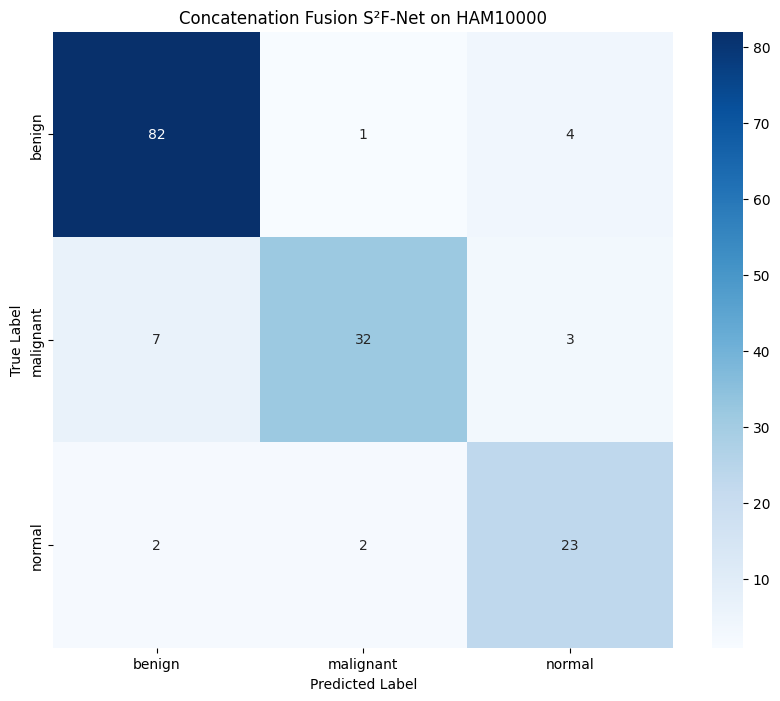


--- Training History Plots ---


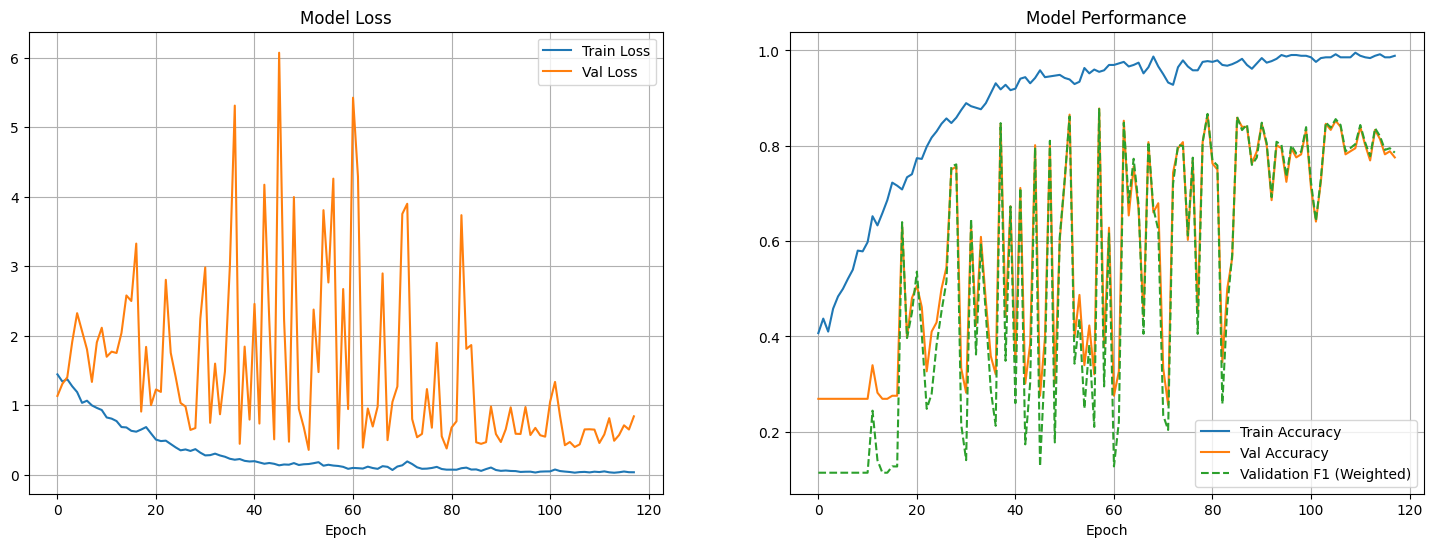


--- ROC Curve Analysis ---


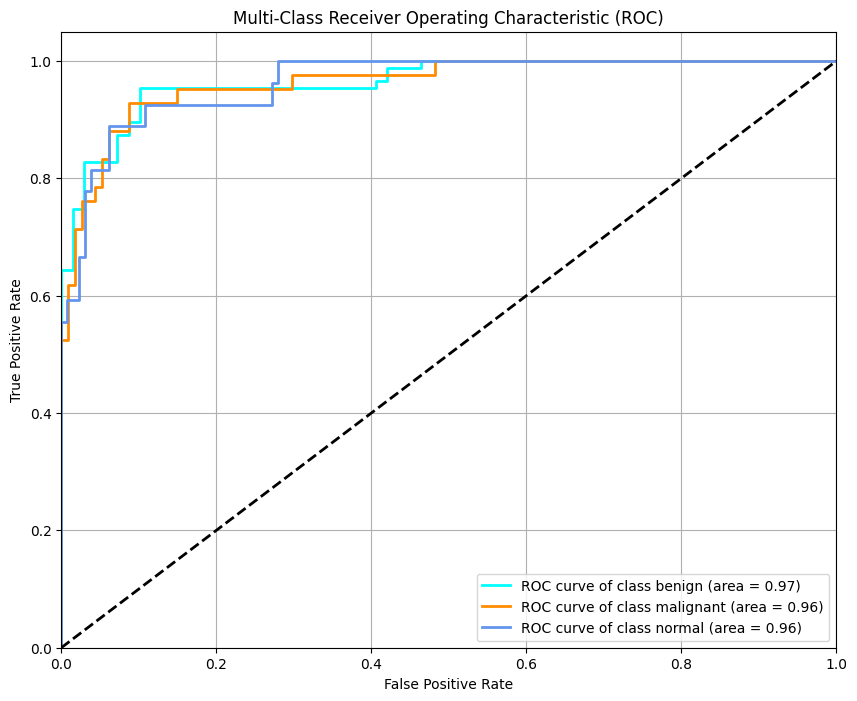


--- Script Finished ---


In [ ]:
# ======================
# BLOCK 5: EVALUATION
# ======================
print("\n\n--- Final Evaluation on BUSI dataset ---")
custom_objects = {'SpectralFilterLayer': SpectralFilterLayer}

try:
    print(f"Loading best model from: {CLASSIFIER_MODEL_PATH}")
    best_model = models.load_model(
        CLASSIFIER_MODEL_PATH,
        custom_objects = custom_objects}
    )

    # --- 1. Evaluating Loss and Accuracy ---
    print("\n--- Calculating Loss and Accuracy on Test Set ---")
    loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss:      {loss:.4f}")
    print(f"Test Accuracy:  {accuracy:.4f}")

    # --- 2. Getting Predictions ---
    y_pred_proba = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_proba, axis=1)

    # --- 3. Detailed Metrics ---
    print("\n--- Detailed Performance Metrics ---")
    macro_f1 = f1_score(y_test, y_pred_classes, average='macro', zero_division=0)
    weighted_f1 = f1_score(y_test, y_pred_classes, average='weighted', zero_division=0)
    print(f"Macro F1 Score:   {macro_f1:.4f}")
    print(f"Weighted F1 Score:{weighted_f1:.4f}")

    kappa = cohen_kappa_score(y_test, y_pred_classes)
    mcc = matthews_corrcoef(y_test, y_pred_classes)
    print(f"Cohen's Kappa:    {kappa:.4f}")
    print(f"MCC:              {mcc:.4f}")

    auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
    weighted_auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    print(f"AUC-ROC (Macro):  {auc_roc:.4f}")
    print(f"AUC-ROC (Weighted):{weighted_auc_roc:.4f}")

    # --- 4. Classification Report ---
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred_classes, target_names=CLASS_NAMES, digits=4, zero_division=0))

    # --- 5. Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    # plt.title('Concatenation Fusion S³F-Net on BUSI')       # It was set to HAM10000 by mistake while running the script
    plt.show()

    # --- 6. Plotting Training History ---
    if 'history' in locals() or 'history' in globals():
        print("\n--- Training History Plots ---")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
        ax1.plot(history.history['loss'], label='Train Loss')
        ax1.plot(history.history['val_loss'], label='Val Loss')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.legend()
        ax1.grid(True)
        ax2.plot(history.history['accuracy'], label='Train Accuracy')
        ax2.plot(history.history['val_accuracy'], label='Val Accuracy')
        if 'val_f1_weighted' in history.history:
            ax2.plot(history.history['val_f1_weighted'], label='Validation F1 (Weighted)', linestyle='--')
        ax2.set_title('Model Performance')
        ax2.set_xlabel('Epoch')
        ax2.legend()
        ax2.grid(True)
        plt.show()

    # --- 7. ROC Curve Plot ---
    print("\n--- ROC Curve Analysis ---")
    y_test_binarized = label_binarize(y_test, classes=range(len(CLASS_NAMES)))
    n_classes = y_test_binarized.shape[1]
    fpr, tpr, roc_auc_dict = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc_dict[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {CLASS_NAMES[i]} (area = {roc_auc_dict[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Multi-Class Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"An error occurred during evaluation: {e}")

print("\n--- Script Finished ---")